# Задача классификации рукописных арабских цифр

*На основе практической работы на семинаре Intel 24-го апреля, проходивший на площадке Selectel в Санкт-Петербурге*.

In [1]:
import numpy
import time
import matplotlib.pyplot as plt

import sklearn
import sklearn.datasets # load_digits()
import sklearn.cluster # KMeans
import sklearn.decomposition # PCA
import sklearn.metrics

import math

%matplotlib inline

## 1. Загрузка данных

In [2]:
digits = sklearn.datasets.load_digits()
data = digits['data']
labels = digits['target']

In [3]:
data

array([[ 0.,  0.,  5., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ..., 10.,  0.,  0.],
       [ 0.,  0.,  0., ..., 16.,  9.,  0.],
       ...,
       [ 0.,  0.,  1., ...,  6.,  0.,  0.],
       [ 0.,  0.,  2., ..., 12.,  0.,  0.],
       [ 0.,  0., 10., ..., 12.,  1.,  0.]])

In [4]:
len(data), len(data[0])

(1797, 64)

Посмотрим минимальные и максимальные значение пикселей:

In [5]:
min([min(v) for v in data]), max([max(v) for v in data])

(0.0, 16.0)

А также метки и их количество:

In [6]:
labels, sorted(set(labels))

(array([0, 1, 2, ..., 8, 9, 8]), [0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

In [7]:
len(labels)

1797

__Итак, в размеченном наборе данных всего 1797 цифр, каждая представлена одномерным массивом из 64 элементов (8x8 пикселей)__.

Так они выглядят (первые 50 изображений).

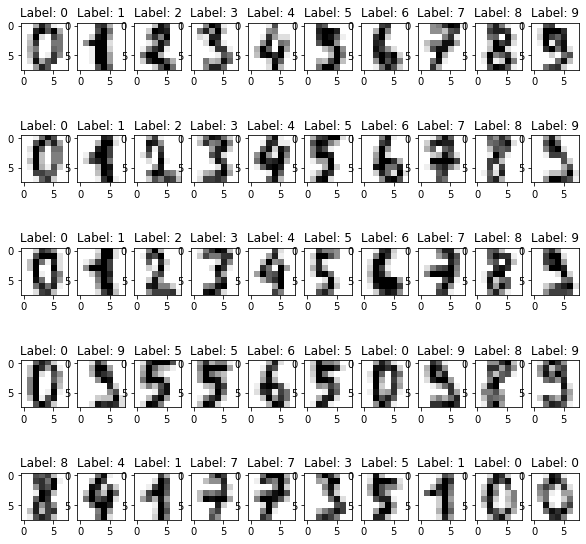

In [8]:
plt.figure(figsize=(10,10))
for i in range(50):
    plt.subplot(5, 10, i + 1)
    plt.imshow(digits.images[i], cmap=plt.cm.gray_r, interpolation='nearest')
    plt.title(f'Label: {labels[i]}')

## 2. Используемые методы (немного матана)

### Алгоритм K-Means:
K-Means это один из самых используемых алгоритмов кластеризации.
По данным и числу кластеров $k$, он итеративно вычисляет распределение объектов по k кластерам {$S_1, \dots, S_k$} и центры кластеров, минимизируя суммарное расстояние от центров кластеров до объектов, которые к ним относятся:

$$\sum\limits_{i=1}^{k} \sum\limits_{j:x_j\in S_i}^n\|x_j-m_i\|^2$$
Где $k$ число кластеров, $n$ число объектов, $S_i$ это $i$-ый кластер с центром в  $m_i$, $x_j$ это $j$-ый объект.

### Алгоритм PCA (Principal Component Analysis):

PCA это один из самых часто используемых алгоритмов для снижения размерности данных. 
Для снижения размерности матрицы объекты-признаки с $X \in R^{l \times D}$ до  $X \in R^{l \times d}$ этот алгоритм ищет $d$ ортогональных векторов $u_1, \dots, u_d$, таких, что при проекции на них дисперсия (разброс) данных будет наибольшей. 

Решением являются векторы $\lambda_1, \dots, \lambda_d$ - собственные векторы матрицы ковариаций признаков $X^T X$, соответствующие наибольшим собственным значениям. 


## 3. Уменьшим размерность с помощью PCA (Principal Component Analysis)

**Original data**: {{len(data)}} samples, {{len(data[0])}} each

In [9]:
%%time
pca = sklearn.decomposition.PCA(n_components=0.8)
pca.fit(data)
data_reduced = pca.transform(data)

Wall time: 106 ms


After PCA: **Reduced data**: {{len(data_reduced)}} samples, {{len(data_reduced[0])}} each

__Таким образом, от элементов размера 64 мы перешли к элементам меньшей размерности (в данном случае, размерность равна {{len(data_reduced[0])}})__.

## 4. Кластеризация с помощью алгоритма K-means 

In [10]:
%%time
kmeans = sklearn.cluster.KMeans(n_clusters=10)
kmeans.fit(data_reduced)

Wall time: 397 ms


KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=10, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)

Посмотрим теперь, как разложились входные данные по кластерам. Если построить гистограмму (можно мысленно), то легко оценить качество получившегося разбиения по входным меткам.

In [11]:
kmeans.labels_, len(kmeans.labels_)

(array([6, 2, 2, ..., 2, 3, 3]), 1797)

In [12]:
cluster_mapping = {i: [0 for j in range(10)] for i in range(10)}
for l, k in zip(labels, kmeans.labels_):
    cluster_mapping[l][k] += 1
cluster_mapping  

{0: [0, 0, 0, 0, 0, 0, 177, 0, 0, 1],
 1: [24, 56, 98, 0, 2, 1, 0, 0, 1, 0],
 2: [152, 1, 10, 0, 0, 0, 1, 3, 10, 0],
 3: [1, 0, 7, 10, 0, 2, 0, 7, 156, 0],
 4: [0, 4, 5, 0, 0, 0, 0, 5, 0, 167],
 5: [0, 0, 0, 41, 1, 136, 0, 0, 2, 2],
 6: [0, 0, 3, 0, 177, 0, 1, 0, 0, 0],
 7: [0, 1, 16, 0, 0, 0, 0, 162, 0, 0],
 8: [3, 7, 99, 45, 2, 8, 0, 6, 4, 0],
 9: [0, 20, 1, 139, 0, 6, 0, 8, 6, 0]}

Итак, можно предположить по принципу простого большинства такое прямое соответствие:

In [13]:
for k, v in cluster_mapping.items():
    print(f'{k} <= {v.index(max(v))}')

0 <= 6
1 <= 2
2 <= 0
3 <= 8
4 <= 9
5 <= 5
6 <= 4
7 <= 7
8 <= 2
9 <= 3


__Оценим качество кластеризации *как полагается* по науке__

- Homogenity: http://scikit-learn.org/stable/modules/generated/sklearn.metrics.homogeneity_score.html
- Completeness: http://scikit-learn.org/stable/modules/generated/sklearn.metrics.completeness_score.html
- V-Measure: http://scikit-learn.org/stable/modules/generated/sklearn.metrics.v_measure_score.html

In [14]:
print("Homogeneity: %0.3f" % sklearn.metrics.homogeneity_score(labels, kmeans.labels_))
print("Completeness: %0.3f" % sklearn.metrics.completeness_score(labels, kmeans.labels_))
print("V-measure: %0.3f" % sklearn.metrics.v_measure_score(labels, kmeans.labels_))

Homogeneity: 0.733
Completeness: 0.741
V-measure: 0.737


Прямо скажем, не очень. На самом деле, вот это самое "не очень" хорошо видно уже из таблички **cluster_mapping**, которая была подсчитана выше.

In [15]:
# Uncomment below if you want to have a scatter plot of allocated clusters.
# Note that the code below is for 2d space, for 3d some modifications needed (some of them are commented out below)
# for 4d and higher dimensions, please, go to astral..

# assignments = kmeans.labels_
# centroids = kmeans.cluster_centers_

# from mpl_toolkits.mplot3d import Axes3D # for 3D plots this is needed

# plt.set_cmap(plt.cm.Dark2)
# plt.clf()
# fig = plt.figure(figsize=(5,5)) #, projection='3d')
# ax = fig.add_subplot(111) #, projection='3d')
# ax.scatter(data_reduced[:, 0], data_reduced[:, 1], s=50, c=assignments, alpha=0.5)
# ax.scatter(centroids[:, 0], centroids[:, 1], marker='o', s=180, linewidths=4, color='black')
# ax.xaxis.set_ticklabels([])
# ax.yaxis.set_ticklabels([])

# plt.show()

Теперь натренированный объект **kmeans** можно использовать для "распознавания" входной цифры. Надо только каждому номеру кластера сопоставить значение цифры.

## 5. Тестовая картинка с цифрой 0, которую мы попытаемся распознать

In [16]:
img = plt.imread('0_small.png')

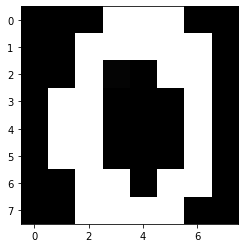

In [17]:
plt.imshow(img, cmap='gray')

In [18]:
len(img), len(img[0]), len(img[0][0])

(8, 8, 3)

Видно, что загруженная PNG картинка устроена по-другому, не так как тестовый набор __digits__ в __sklearn__: это двумерный массив 8x8, каждый элемент которого это RGB-тройка, причем компоненты RGB - это числа с плавающей точкой от 0 до 1. А `sklearn.datasets.load_digits()` возвращает пиксели как число от 0 до 16 (http://scikit-learn.org/stable/modules/generated/sklearn.datasets.load_digits.html).
Таким образом, нам надо свернуть (R,G,B) в одно число с максимальным значением 16. Сделаем это, например, так:

In [19]:
transformed_img = list()
for line in img:
    for pixel in line:
        com_r = pixel[0]
        com_g = pixel[1]
        com_b = pixel[2]
        transformed_img.append(int(math.sqrt(com_r**2 + com_g**2 + com_b**2) * 16 / math.sqrt(3)))

Редуцируем размерность натренированным PCA:

In [20]:
d = pca.transform([transformed_img])
d

array([[ -0.95244057,  29.09234678,  -2.21002985,  18.00210522,
        -15.55873141,  -2.1695782 ,  -2.95674656, -13.63417582,
          1.2111124 ,   8.07130267,  -7.1229315 ,   1.79874596,
         -6.81416315]])

Предсказываем наиболее подходящий номер кластера:

In [21]:
r = kmeans.predict(d)
r

array([6])

## 6. Nota bene  
Если запустить этот блокнот несколько раз, то можно заметить, что при (почти) каждом прогоне тестовому изображению с цифрой *0* будут назначаться разные номера кластеров. То есть, кластеризация - как метод обучения *без учителя* - с параметрами по умолчанию не выдаёт уникальных для каждого обучающего набора результатов. Следовательно, в общем случае каждый раз после кластеризации мы должны обнулять или обновлять полученные на предыдущих прогонах алгоритма результаты.